# Import Libraries

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from farasa.stemmer import FarasaStemmer
import gensim
from nltk.tokenize import RegexpTokenizer


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


import helper

# Read and Clean 

In [3]:
df_train = pd.read_csv(r"data/ArSarcasm_train.csv")
df_test = pd.read_csv(r"data/ArSarcasm_test.csv")

In [4]:
stemmer =  FarasaStemmer(interactive=True)

[2021-06-19 23:48:34,077 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [5]:
df_train['cleaned_tweet'] = df_train['tweet'].apply(helper.clean_tweet)
df_test['cleaned_tweet'] = df_test['tweet'].apply(helper.clean_tweet)

In [6]:
df_train['cleaned_tweet'] = df_train['cleaned_tweet'].apply(lambda x: stemmer.stem(x))
df_test['cleaned_tweet'] = df_test['cleaned_tweet'].apply(lambda x: stemmer.stem(x))

In [7]:
df_train.head()

,dialect,sarcasm,sentiment,original_sentiment,tweet,source,cleaned_tweet
0,gulf,False,negative,negative,"""نصيحه ما عمرك اتنزل لعبة سوبر ماريو مش زي ما ...",semeval,نصيح ما عمر اتنزل لعب سوبر ماريو مش زي ما كان ...
1,msa,False,neutral,positive,"""#نادين_نسيب_نجيم ❤️❤️❤️مجلة #ماري_كلير 💭#ملكة...",semeval,نادين نسيب نجيم مجل ماري كلير ملك صحراء
2,egypt,False,neutral,neutral,"""@Alito_NBA اتوقع انه بيستمر""",semeval,أتوقع ان استمر
3,levant,True,neutral,negative,"""@KSA24 يعني ""بموافقتنا"" لأن دمشق صايرة موسكو""",semeval,عنى موافقة لان دمشق صاير موسكو
4,msa,False,neutral,negative,"""RT @alaahmad20: قائد في الحرس يعترف بفقدان ال...",semeval,قائد في حرس اعترف فقدان سيطره امنيه في شرقي غر...


In [8]:
df_test.head()

,tweet,sarcasm,sentiment,dialect,cleaned_tweet
0,اخوي حانق يالغلا وشفيك معصب؟ عادي تراهم بشر يف...,False,NEG,msa,اخوي حانق يالغلا شفي معصب عادي رأى بشر فطر صبح...
1,اف مو متعوده عليهم سته https://t.co/8igFPx1i26,True,NEG,msa,اف مو متعود على سته
2,اللهم اشفِ مرضانا ومرضى المسلمين . . ♥️,False,POS,msa,اللهم اشف مرض مرض مسلم
3,ابشركم طلقت السات 😘.,False,POS,gulf,ابشر طلق سات
4,مؤشر خطير: ٩٠٪ من الشخصيات البرلمانية في الكوي...,True,NEG,msa,مؤشر خطير من شخصية برلمانيه في كويت تعرض الي ا...


# Remove stopwords

In [9]:
df_train["cleaned_tweet"] = df_train["cleaned_tweet"].apply(helper.remove_stopWords)
df_test["cleaned_tweet"] = df_test["cleaned_tweet"].apply(helper.remove_stopWords)

In [10]:
df_train.head()

,dialect,sarcasm,sentiment,original_sentiment,tweet,source,cleaned_tweet
0,gulf,False,negative,negative,"""نصيحه ما عمرك اتنزل لعبة سوبر ماريو مش زي ما ...",semeval,نصيح عمر اتنزل لعب سوبر ماريو مش زي متوقع الله...
1,msa,False,neutral,positive,"""#نادين_نسيب_نجيم ❤️❤️❤️مجلة #ماري_كلير 💭#ملكة...",semeval,نادين نسيب نجيم مجل ماري كلير ملك صحراء
2,egypt,False,neutral,neutral,"""@Alito_NBA اتوقع انه بيستمر""",semeval,أتوقع ان استمر
3,levant,True,neutral,negative,"""@KSA24 يعني ""بموافقتنا"" لأن دمشق صايرة موسكو""",semeval,عنى موافقة لان دمشق صاير موسكو
4,msa,False,neutral,negative,"""RT @alaahmad20: قائد في الحرس يعترف بفقدان ال...",semeval,قائد حرس اعترف فقدان سيطره امنيه إيران احواز ا...


# Build our Vocab List

In [11]:
vocab = []
for tw in df_train['cleaned_tweet']:
    for word in tw.split():
        if word not in vocab:
            vocab.append(word)

vocab = sorted(vocab)

In [12]:
print(len(vocab))

15198


# Prepare Data to Train

In [13]:
train_data = df_train[['sarcasm', 'cleaned_tweet']]
test_data = df_test[['sarcasm', 'cleaned_tweet']]

In [14]:
train_data['sarcasm'] = train_data['sarcasm'].apply(lambda x: 1 if x==True else 0)
test_data['sarcasm'] = test_data['sarcasm'].apply(lambda x: 1 if x==True else 0)

<ipython-input-14-8cb7745a2a45>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['sarcasm'] = train_data['sarcasm'].apply(lambda x: 1 if x==True else 0)
<ipython-input-14-8cb7745a2a45>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['sarcasm'] = test_data['sarcasm'].apply(lambda x: 1 if x==True else 0)


In [15]:
train_data.drop_duplicates(inplace=True)
test_data.drop_duplicates(inplace=True)
X_train = train_data['cleaned_tweet']
X_test = test_data['cleaned_tweet']
y_train = train_data['sarcasm'].tolist()
y_test = test_data['sarcasm'].tolist()

print('Size of train data: {}'.format(len(X_train)))
print('Size of test data: {}'.format(len(X_test)))
print('Size of train labels: {}'.format(len(y_train)))
print('Size of test labels: {}'.format(len(y_test)))

Size of train data: 8180
Size of test data: 2980
Size of train labels: 8180
Size of test labels: 2980


<ipython-input-15-9b13ab82f2b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop_duplicates(inplace=True)
<ipython-input-15-9b13ab82f2b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop_duplicates(inplace=True)


In [16]:
tokenizer = RegexpTokenizer(r'\w+')

X_train_tokens = train_data['cleaned_tweet'].apply(tokenizer.tokenize)
X_test_tokens = test_data['cleaned_tweet'].apply(tokenizer.tokenize)

# Fitting First Classifier (Logistic Regression)

## Train the Model

# 1- Bag of Word

In [17]:
X_train_bow_emb, count_vectorizer = helper.bow_emb(X_train)
X_test_bow_emb = count_vectorizer.transform(X_test)

## Visualize BOW

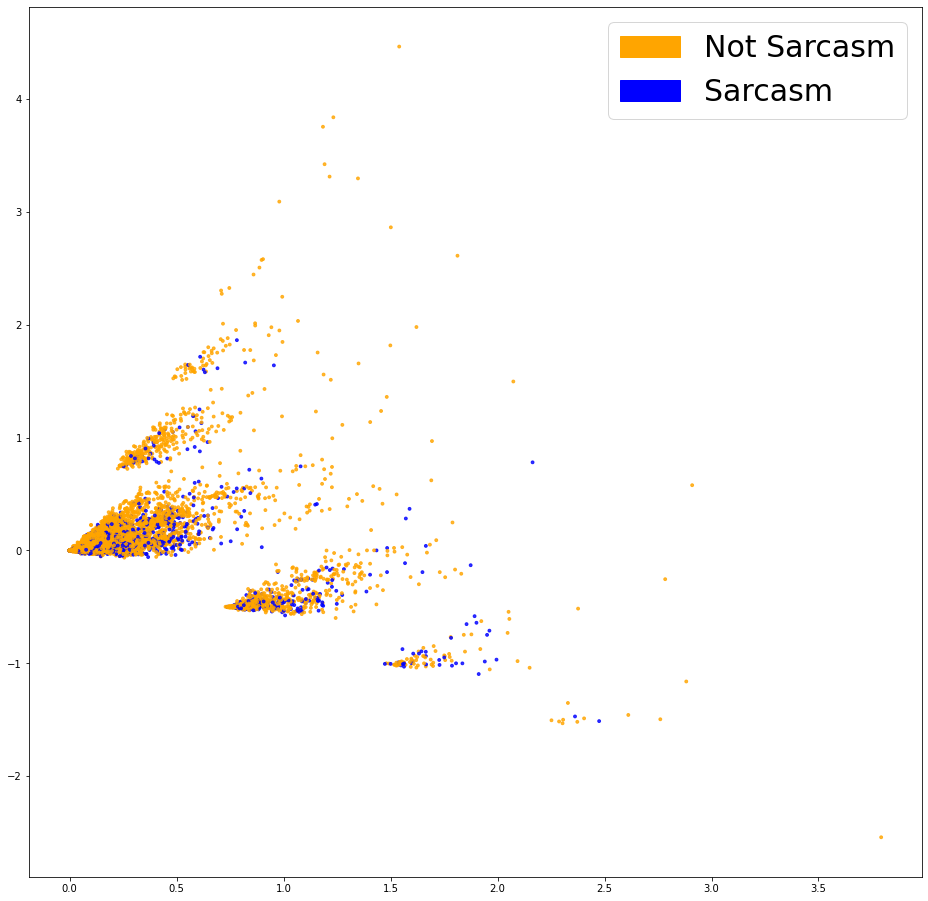

In [20]:
fig = plt.figure(figsize=(16, 16))          
helper.plot_LSA(X_train_bow_emb, y_train)
plt.show()

In [21]:
lr_bow = LogisticRegression(solver='newton-cg', class_weight='balanced')
lr_bow.fit(X_train_bow_emb, y_train)

# Predicting on the test data
pred_test = lr_bow.predict(X_test_bow_emb)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
precision_test = precision_score(y_test, pred_test)
recall_test = recall_score(y_test, pred_test)
accuracy_test = accuracy_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)
print('The precision score for the testing data:', precision_test)
print('The recall score for the testing data:', recall_test)
print('The accuracy score for the testing data:', accuracy_test)


The f1 score for the testing data: 0.4253835425383543
The precision score for the testing data: 0.49512987012987014
The recall score for the testing data: 0.37286063569682154
The accuracy score for the testing data: 0.723489932885906


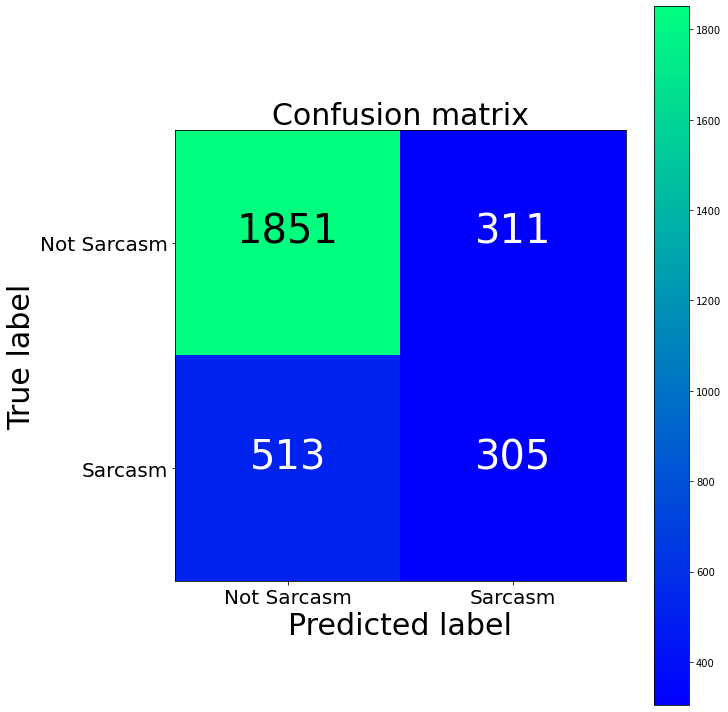

In [22]:
cm = confusion_matrix(y_test, pred_test)
fig = plt.figure(figsize=(10, 10))
plot = helper.plot_confusion_matrix(cm, classes=['Not Sarcasm','Sarcasm'], normalize=False, title='Confusion matrix')
plt.show()

## Handel the Imbalace Manually

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\users\moamen\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scoring for different class weights')

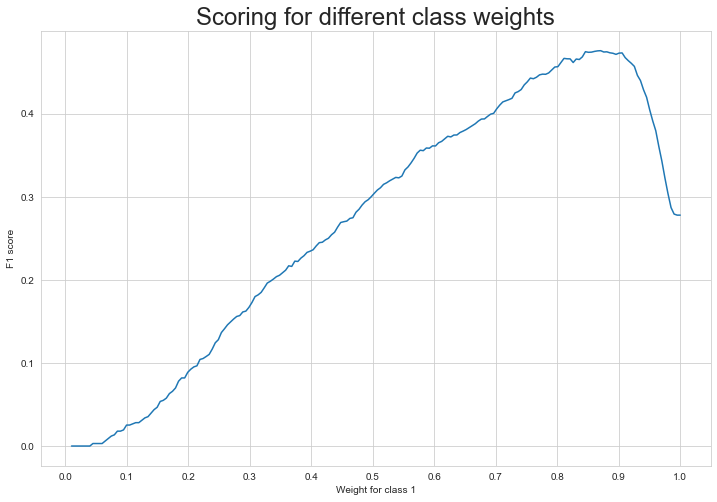

In [28]:
lr_bow = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr_bow, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train_bow_emb, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [29]:
weight_for_high_score = weigh_data[weigh_data['score'] == np.max(weigh_data.score)]['weight']
weight_for_high_score

26    0.870653
Name: weight, dtype: float64

The f1 score for the testing data: 0.4648390941597139
The precision score for the testing data: 0.45348837209302323
The recall score for the testing data: 0.4767726161369193
The accuracy score for the testing data: 0.6986577181208053


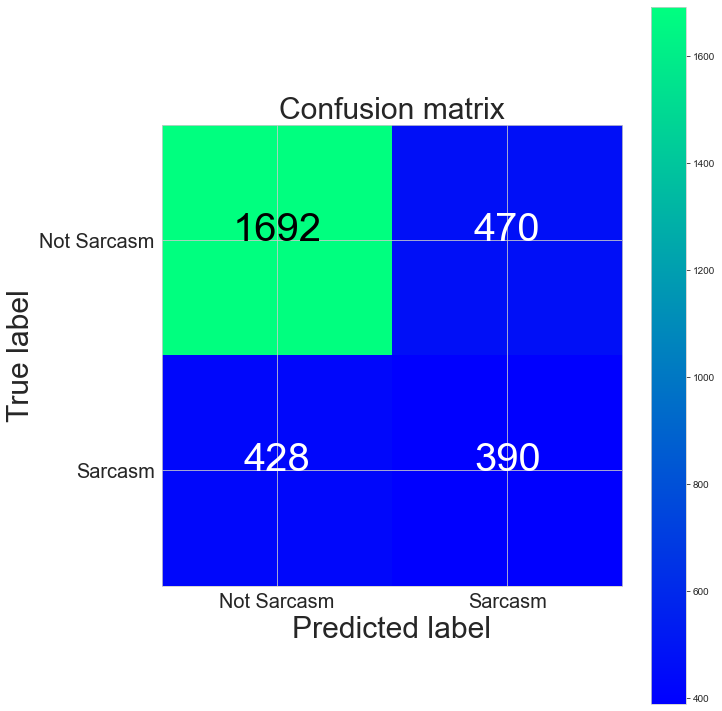

In [30]:
lr_bow = LogisticRegression(solver='newton-cg', class_weight={0: 1-weight_for_high_score, 1: weight_for_high_score})
lr_bow.fit(X_train_bow_emb, y_train)

# Predicting on the test data
pred_test = lr_bow.predict(X_test_bow_emb)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
precision_test = precision_score(y_test, pred_test)
recall_test = recall_score(y_test, pred_test)
accuracy_test = accuracy_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)
print('The precision score for the testing data:', precision_test)
print('The recall score for the testing data:', recall_test)
print('The accuracy score for the testing data:', accuracy_test)

#Ploting the confusion matrix
cm = confusion_matrix(y_test, pred_test)
fig = plt.figure(figsize=(10, 10))
plot = helper.plot_confusion_matrix(cm, classes=['Not Sarcasm','Sarcasm'], normalize=False, title='Confusion matrix')
plt.show()

In [33]:
importance = helper.get_most_important_features(count_vectorizer, lr_bow, 10)

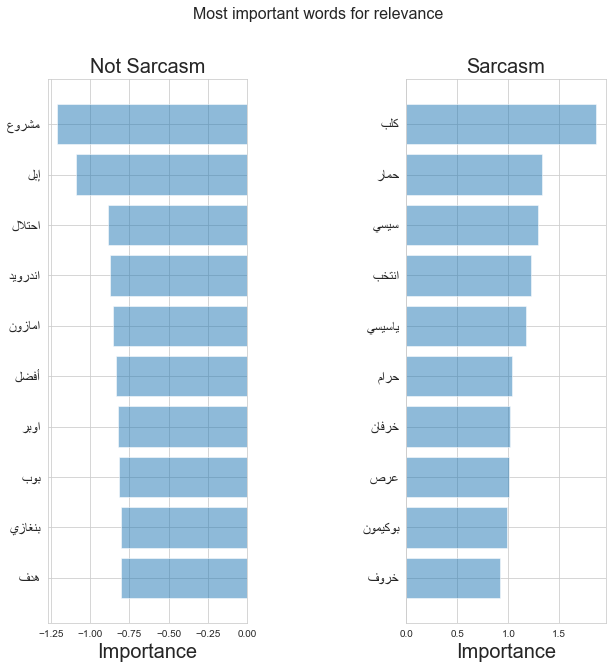

In [34]:
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

helper.plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

# 2- TF-IDF

In [35]:
X_train_tfidf_emb, tfidf_vectorizer = helper.tfidf(X_train)
X_test_tfidf_emb = tfidf_vectorizer.transform(X_test)

## Visualize TF-IDF

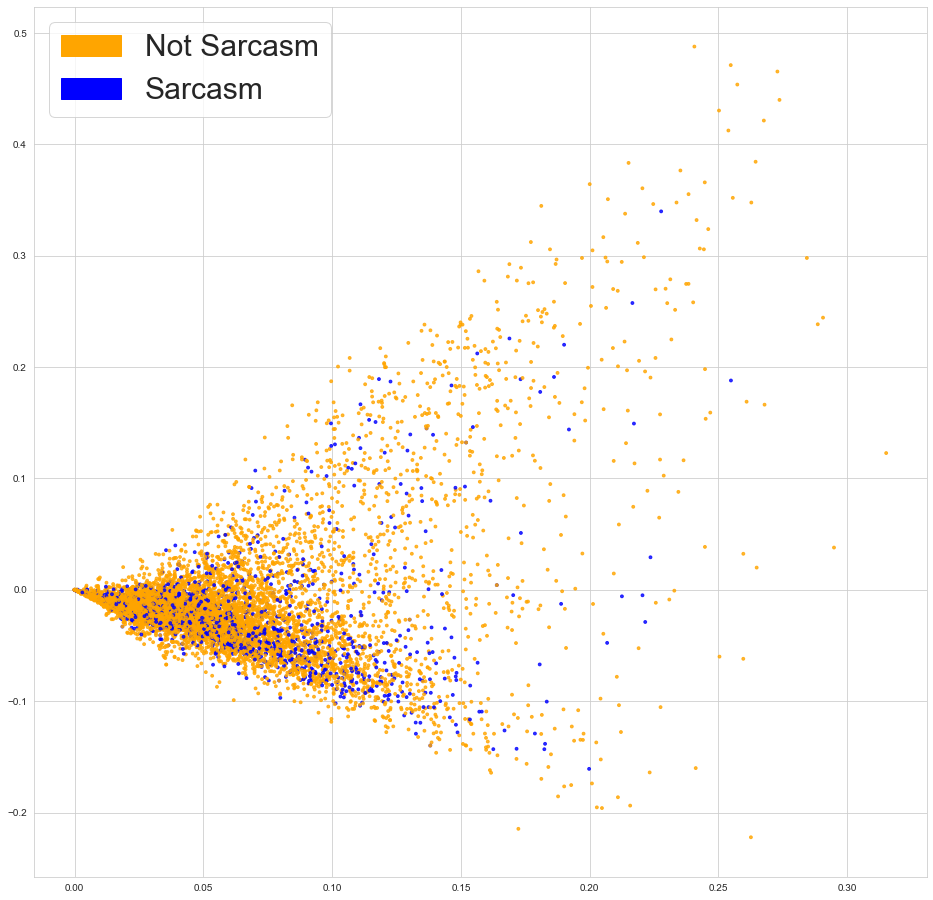

In [36]:
fig = plt.figure(figsize=(16, 16))          
helper.plot_LSA(X_train_tfidf_emb, y_train)
plt.show()

In [37]:
lr_tfidf = LogisticRegression(solver='newton-cg', class_weight='balanced')
lr_tfidf.fit(X_train_tfidf_emb, y_train)

# Predicting on the test data
pred_test = lr_tfidf.predict(X_test_tfidf_emb)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
precision_test = precision_score(y_test, pred_test)
recall_test = recall_score(y_test, pred_test)
accuracy_test = accuracy_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)
print('The precision score for the testing data:', precision_test)
print('The recall score for the testing data:', recall_test)
print('The accuracy score for the testing data:', accuracy_test)

The f1 score for the testing data: 0.4611679711017459
The precision score for the testing data: 0.4543297746144721
The recall score for the testing data: 0.4682151589242054
The accuracy score for the testing data: 0.6996644295302014


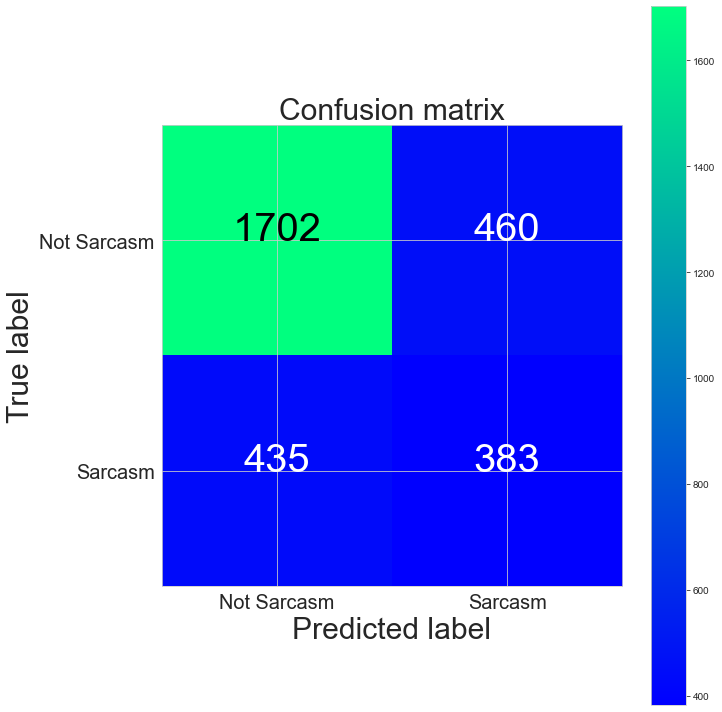

In [38]:
cm = confusion_matrix(y_test, pred_test)
fig = plt.figure(figsize=(10, 10))
plot = helper.plot_confusion_matrix(cm, classes=['Not Sarcasm','Sarcasm'], normalize=False, title='Confusion matrix')
plt.show()

## Handel the Imbalace Manually

The f1 score for the testing data: 0.48633210934312526
The precision score for the testing data: 0.3649724433557869
The recall score for the testing data: 0.7286063569682152
The accuracy score for the testing data: 0.5775167785234899


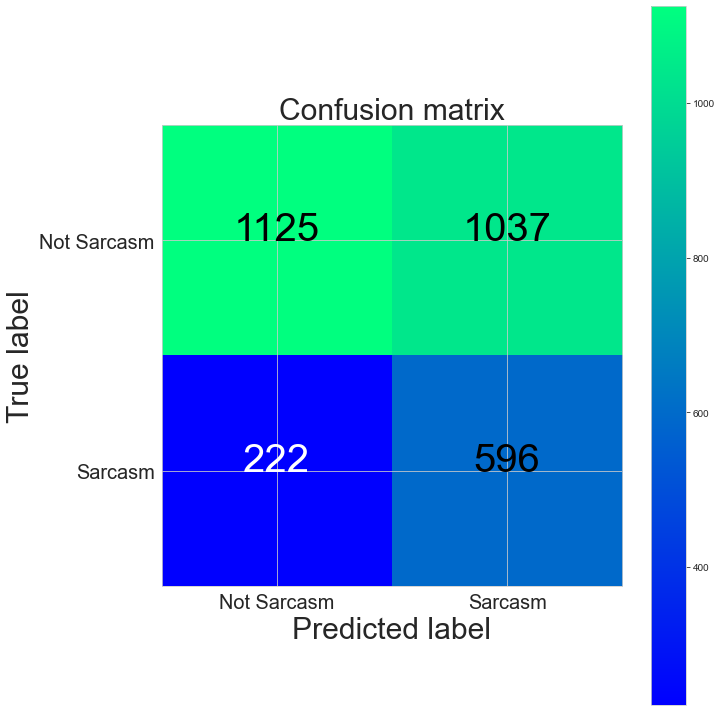

In [39]:
lr_tfidf = LogisticRegression(solver='newton-cg', class_weight={0: 1-weight_for_high_score, 1: weight_for_high_score})
lr_tfidf.fit(X_train_tfidf_emb, y_train)

# Predicting on the test data
pred_test = lr_tfidf.predict(X_test_tfidf_emb)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
precision_test = precision_score(y_test, pred_test)
recall_test = recall_score(y_test, pred_test)
accuracy_test = accuracy_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)
print('The precision score for the testing data:', precision_test)
print('The recall score for the testing data:', recall_test)
print('The accuracy score for the testing data:', accuracy_test)

#Ploting the confusion matrix
cm = confusion_matrix(y_test, pred_test)
fig = plt.figure(figsize=(10, 10))
plot = helper.plot_confusion_matrix(cm, classes=['Not Sarcasm','Sarcasm'], normalize=False, title='Confusion matrix')
plt.show()

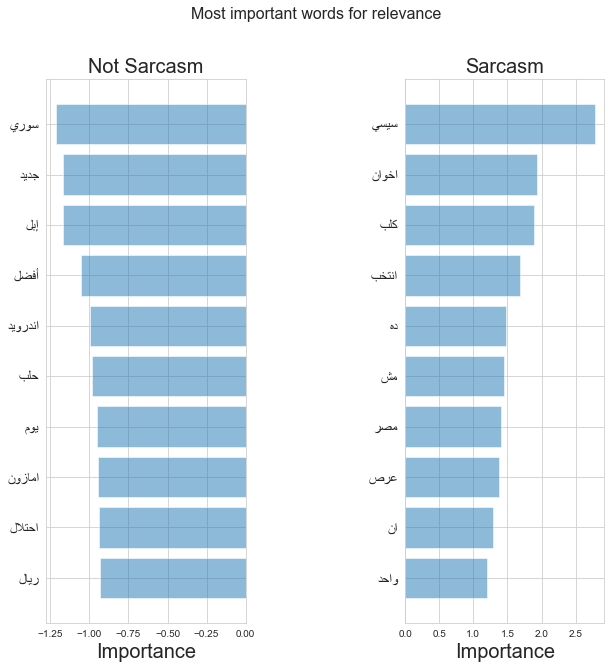

In [40]:
importance = helper.get_most_important_features(tfidf_vectorizer, lr_tfidf, 10)

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

helper.plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

# 3- Pre-trained Word2Vec Model

In [41]:
LEN_OF_TRAIN_TWEETS = [len(i) for i in X_train]
NUM_TRAIN_WORDS = sum(LEN_OF_TRAIN_TWEETS)
TRAIN_MAX_LEN = max(LEN_OF_TRAIN_TWEETS)

LEN_OF_TEST_TWEETS = [len(i) for i in X_test]
NUM_TEST_WORDS = sum(LEN_OF_TEST_TWEETS)
TEST_MAX_LEN = max(LEN_OF_TEST_TWEETS)

In [42]:
train_tokenizer = Tokenizer(nb_words = NUM_TRAIN_WORDS)
train_tokenizer.fit_on_texts(X_train)
train_seq = train_tokenizer.texts_to_sequences(X_train)

test_tokenizer = Tokenizer(nb_words = NUM_TEST_WORDS)
test_tokenizer.fit_on_texts(X_test)
test_seq = test_tokenizer.texts_to_sequences(X_test)

c:\users\moamen\appdata\local\programs\python\python39\lib\site-packages\keras_preprocessing\text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [43]:
X_train_padding = pad_sequences(train_seq, maxlen=TRAIN_MAX_LEN, padding='post')
X_test_padding = pad_sequences(test_seq, maxlen=TEST_MAX_LEN, padding='post')

In [44]:
print(X_train_padding.shape)
print(X_test_padding.shape)

(8180, 116)
(2980, 238)


In [45]:
word2vec_path = "sg_100.bin"
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True, unicode_errors='ignore')   

In [46]:
train_embeddings = helper.get_word2vec_embeddings(model, X_train_tokens)
test_embeddings = helper.get_word2vec_embeddings(model, X_test_tokens)

## Visualize W2V

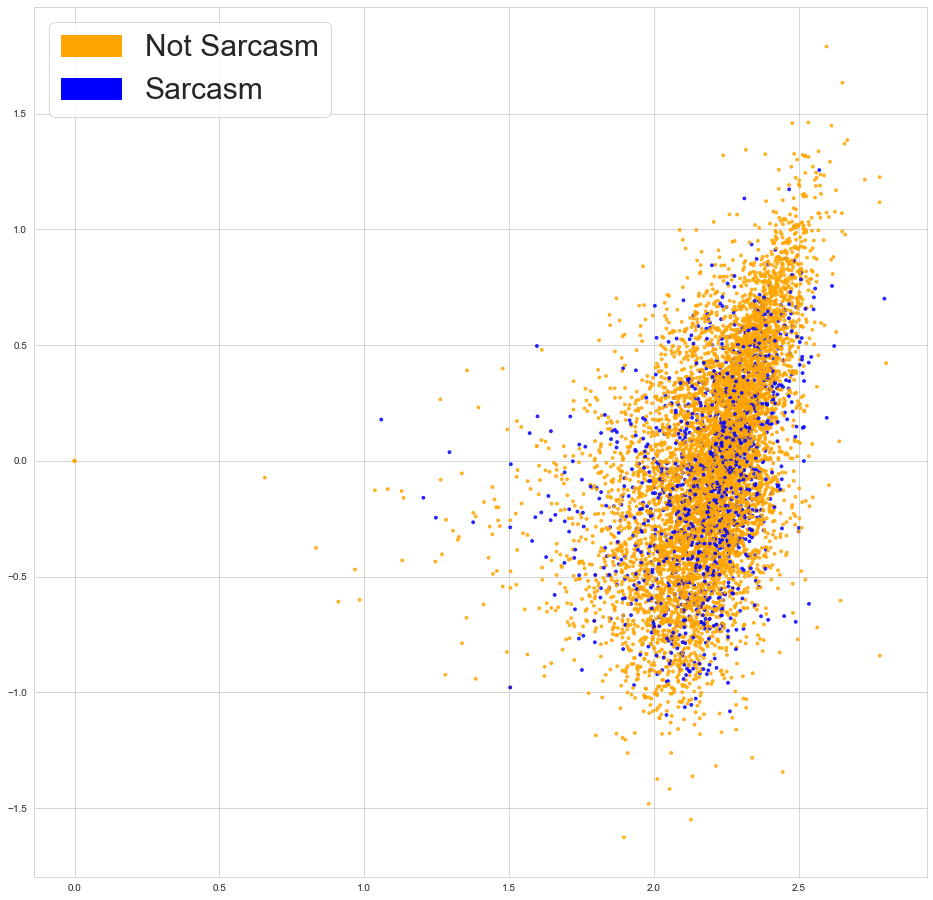

In [47]:
fig = plt.figure(figsize=(16, 16))          
helper.plot_LSA(train_embeddings, y_train)
plt.show()

The f1 score for the testing data: 0.5068299576071597
The precision score for the testing data: 0.41226053639846744
The recall score for the testing data: 0.6577017114914425
The accuracy score for the testing data: 0.6486577181208054


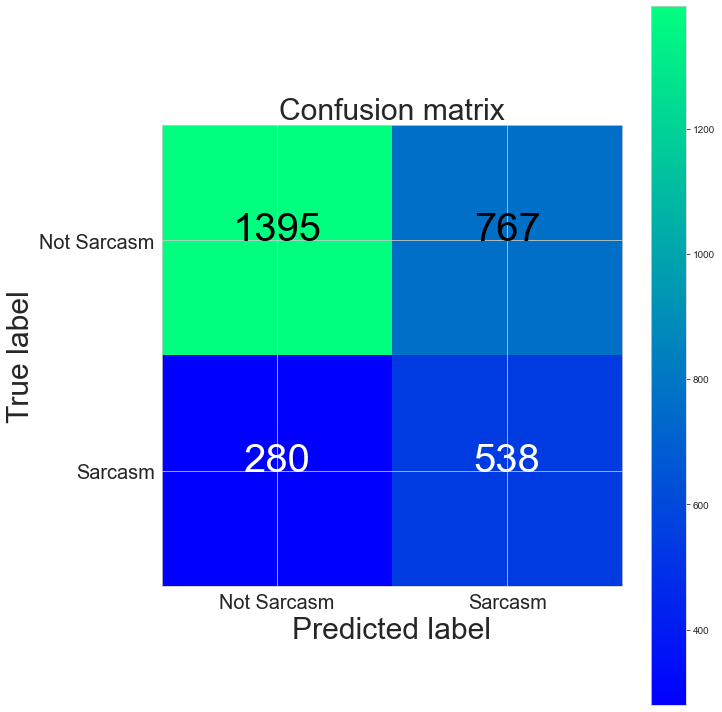

In [48]:
lr_w2v = LogisticRegression(solver='newton-cg', class_weight='balanced')
lr_w2v.fit(train_embeddings, y_train)

# Predicting on the test data
pred_test = lr_w2v.predict(test_embeddings)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
precision_test = precision_score(y_test, pred_test)
recall_test = recall_score(y_test, pred_test)
accuracy_test = accuracy_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)
print('The precision score for the testing data:', precision_test)
print('The recall score for the testing data:', recall_test)
print('The accuracy score for the testing data:', accuracy_test)

#Ploting the confusion matrix
cm = confusion_matrix(y_test, pred_test)
fig = plt.figure(figsize=(10, 10))
plot = helper.plot_confusion_matrix(cm, classes=['Not Sarcasm','Sarcasm'], normalize=False, title='Confusion matrix')
plt.show()

The f1 score for the testing data: 0.523356401384083
The precision score for the testing data: 0.4049531459170013
The recall score for the testing data: 0.7396088019559902
The accuracy score for the testing data: 0.6302013422818792


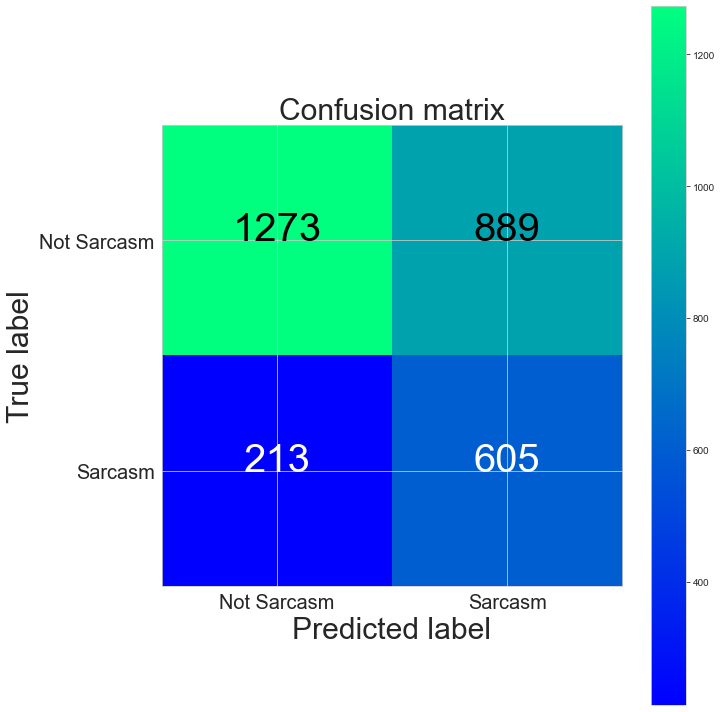

In [49]:
lr_w2v = LogisticRegression(solver='newton-cg', class_weight={0: 1-weight_for_high_score, 1: weight_for_high_score})
lr_w2v.fit(train_embeddings, y_train)

# Predicting on the test data
pred_test = lr_w2v.predict(test_embeddings)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
precision_test = precision_score(y_test, pred_test)
recall_test = recall_score(y_test, pred_test)
accuracy_test = accuracy_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)
print('The precision score for the testing data:', precision_test)
print('The recall score for the testing data:', recall_test)
print('The accuracy score for the testing data:', accuracy_test)

#Ploting the confusion matrix
cm = confusion_matrix(y_test, pred_test)
fig = plt.figure(figsize=(10, 10))
plot = helper.plot_confusion_matrix(cm, classes=['Not Sarcasm','Sarcasm'], normalize=False, title='Confusion matrix')
plt.show()

# Fitting Second Classifier (Support Vector Machine)

In [44]:
from sklearn.svm import SVC
svm = SVC(class_weight='balanced')
svm.fit(X_train_tfidf_emb, y_train)

# Predicting on the test data
pred_test = svm.predict(X_test_tfidf_emb)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
precision_test = precision_score(y_test, pred_test)
recall_test = recall_score(y_test, pred_test)
accuracy_test = accuracy_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)
print('The precision score for the testing data:', precision_test)
print('The recall score for the testing data:', recall_test)
print('The accuracy score for the testing data:', accuracy_test)


The f1 score for the testing data: 0.37837837837837834
The precision score for the testing data: 0.56
The recall score for the testing data: 0.2857142857142857
The accuracy score for the testing data: 0.8461538461538461


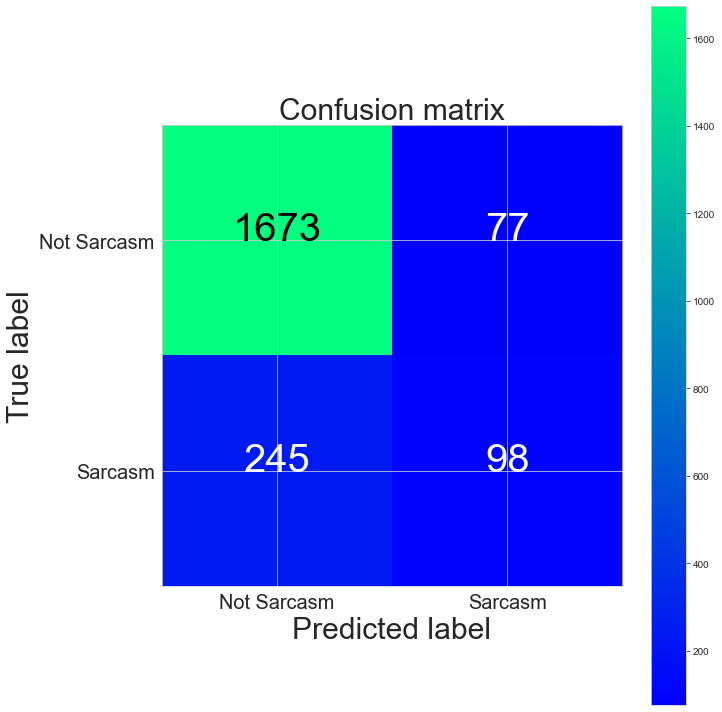

[[1673   77]
 [ 245   98]]


In [45]:
cm = confusion_matrix(y_test, pred_test)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Not Sarcasm','Sarcasm'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\users\moamen\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scoring for different class weights')

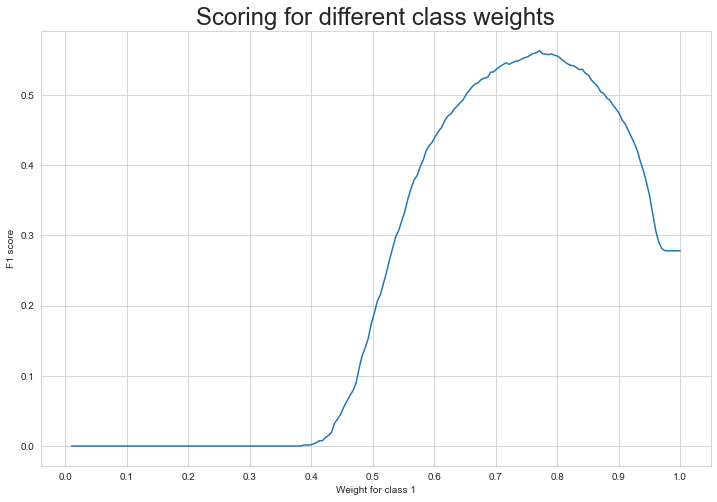

In [46]:
svm = SVC()

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= svm, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(train_embeddings,  y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [47]:
weight_for_high_score = weigh_data[weigh_data['score'] == np.max(weigh_data.score)]['weight']
weight_for_high_score

46    0.771156
Name: weight, dtype: float64

The f1 score for the testing data: 0.5105328376703842
The precision score for the testing data: 0.44396551724137934
The recall score for the testing data: 0.6005830903790087
The accuracy score for the testing data: 0.8112756808408982


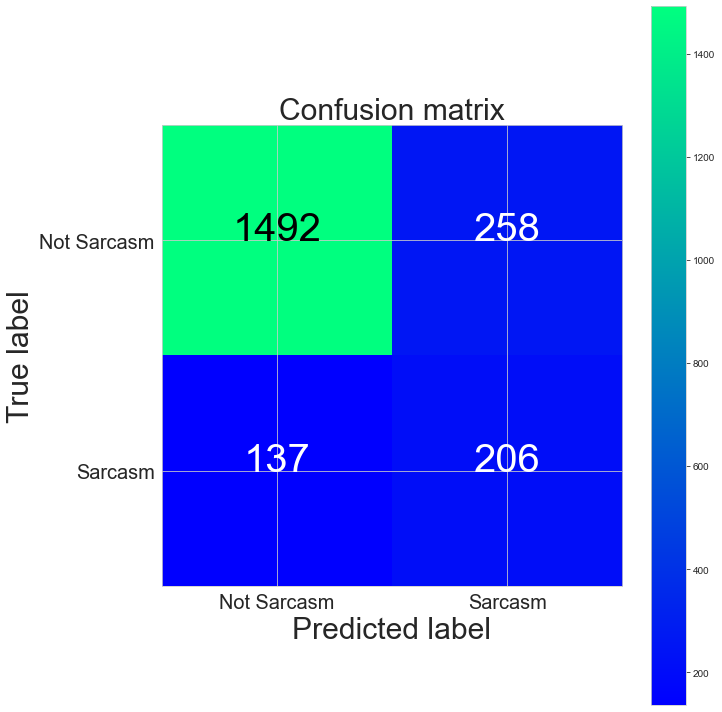

[[1492  258]
 [ 137  206]]


In [48]:
svm = SVC( class_weight={0: 1-weight_for_high_score, 1: weight_for_high_score})
svm.fit(train_embeddings, y_train)

# Predicting on the test data
pred_test = svm.predict(test_embeddings)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
precision_test = precision_score(y_test, pred_test)
recall_test = recall_score(y_test, pred_test)
accuracy_test = accuracy_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)
print('The precision score for the testing data:', precision_test)
print('The recall score for the testing data:', recall_test)
print('The accuracy score for the testing data:', accuracy_test)

#Ploting the confusion matrix
cm = confusion_matrix(y_test, pred_test)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Not Sarcasm','Sarcasm'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

# Other

In [ ]:
def extract_emojis(tweet):
    return list(emojis.get(tweet))

In [ ]:
def contain_emoji(tweet):
    emo_list = list(emojis.get(tweet))
    if emo_list == list():
        return False
    else:
        return True

In [ ]:
df['emoji'] = df['tweet'].apply(extract_emojis)
df.head()

,dialect,sarcasm,sentiment,original_sentiment,tweet,source,cleaned_tweet,emoji
0,gulf,False,negative,negative,"""نصيحه ما عمرك اتنزل لعبة سوبر ماريو مش زي ما ...",semeval,نصيح ما عمر اتنزل لعبة سوبر ماريو مش زي ما كان...,[]
1,msa,False,neutral,positive,"""#نادين_نسيب_نجيم ❤️❤️❤️مجلة #ماري_كلير 💭#ملكة...",semeval,نادين نسيب نجيم مجلة ماري كلير ملك صحراء,"[❤️, 💭, 👑]"
2,egypt,False,neutral,neutral,"""@Alito_NBA اتوقع انه بيستمر""",semeval,أتوقع ان استمر,[]
3,levant,True,neutral,negative,"""@KSA24 يعني ""بموافقتنا"" لأن دمشق صايرة موسكو""",semeval,عنى موافقة أن دمشق صاير موسكو,[]
4,msa,False,neutral,negative,"""RT @alaahmad20: قائد في الحرس يعترف بفقدان ال...",semeval,قائد في حرس اعترف فقدان سيطرة أمني في شرقي و غ...,[]


In [ ]:
df['contain_emoji'] = df['tweet'].apply(contain_emoji)
df.head()

,dialect,sarcasm,sentiment,original_sentiment,tweet,source,cleaned_tweet,emoji,contain_emoji
0,gulf,False,negative,negative,"""نصيحه ما عمرك اتنزل لعبة سوبر ماريو مش زي ما ...",semeval,نصيح ما عمر اتنزل لعبة سوبر ماريو مش زي ما كان...,[],False
1,msa,False,neutral,positive,"""#نادين_نسيب_نجيم ❤️❤️❤️مجلة #ماري_كلير 💭#ملكة...",semeval,نادين نسيب نجيم مجلة ماري كلير ملك صحراء,"[❤️, 💭, 👑]",True
2,egypt,False,neutral,neutral,"""@Alito_NBA اتوقع انه بيستمر""",semeval,أتوقع ان استمر,[],False
3,levant,True,neutral,negative,"""@KSA24 يعني ""بموافقتنا"" لأن دمشق صايرة موسكو""",semeval,عنى موافقة أن دمشق صاير موسكو,[],False
4,msa,False,neutral,negative,"""RT @alaahmad20: قائد في الحرس يعترف بفقدان ال...",semeval,قائد في حرس اعترف فقدان سيطرة أمني في شرقي و غ...,[],False
